/Users/akhyaverma/Documents/infosys/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch 1/70


/Users/akhyaverma/Documents/infosys/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 766us/step - loss: 0.8898 - val_loss: 0.5833
Epoch 2/70
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 745us/step - loss: 0.5844 - val_loss: 0.5756
Epoch 3/70
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 744us/step - loss: 0.5848 - val_loss: 0.5742
Epoch 4/70
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 770us/step - loss: 0.5888 - val_loss: 0.5736
Epoch 5/70
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 719us/step - loss: 0.5854 - val_loss: 0.5731
Epoch 6/70
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 743us/step - loss: 0.5788 - val_loss: 0.5723
Epoch 7/70
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 714us/step - loss: 0.5765 - val_loss: 0.5721
Epoch 8/70
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 714us/step - loss: 0.5775 - val_loss: 0.5720
Epoch 9/70
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 711us/step - loss: 0.5786 - val_loss: 0.5718
Epoch 10/70
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 724us/step - loss: 0.5729 - val_loss: 0.5718
Epoch 11/70
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 713us/step - loss: 0.5836 - val_loss: 0.5717
Epoch 12/70
2500/25

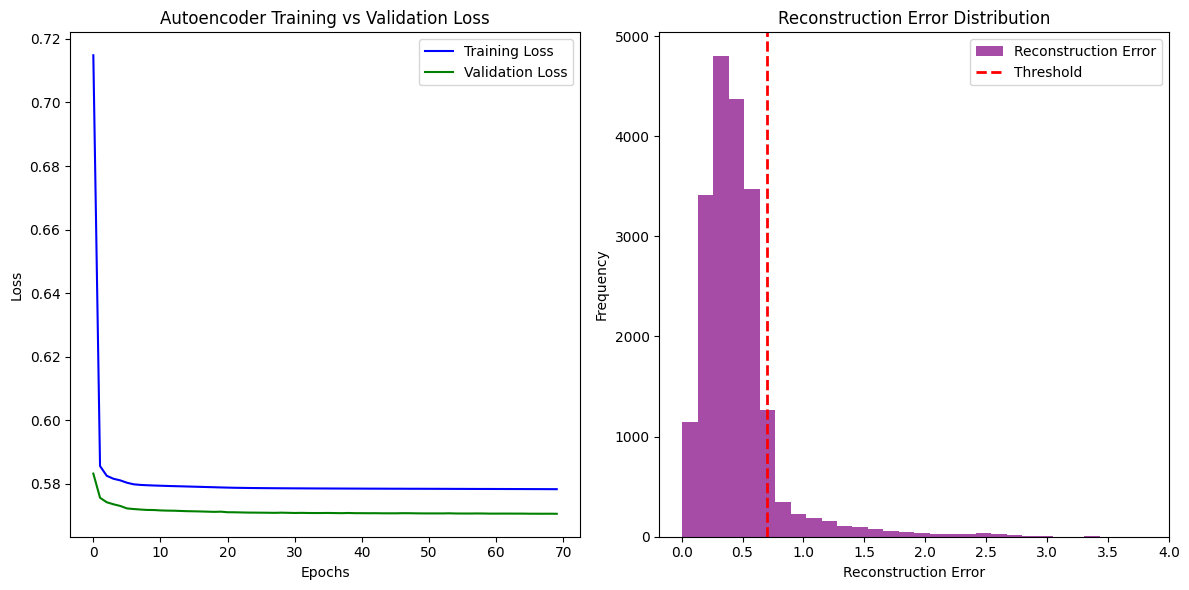

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from keras import layers, models
from keras.optimizers import Adam

# Load and clean the data
data=pd.read_csv('Healthcare _Providers.csv')

data_cleaned = data.drop_duplicates()

# Convert numeric columns to appropriate types
numeric_cols = [
    'Zip Code of the Provider', 'Number of Services', 'Number of Medicare Beneficiaries',
    'Number of Distinct Medicare Beneficiary/Per Day Services', 'Average Medicare Allowed Amount',
    'Average Submitted Charge Amount', 'Average Medicare Payment Amount',
    'Average Medicare Standardized Amount'
]
for col in numeric_cols:
    data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='coerce')

# Encode categorical columns
categorical_cols = [
    'Gender of the Provider', 'Entity Type of the Provider', 'Medicare Participation Indicator',
    'HCPCS Drug Indicator', 'Credentials of the Provider', 'HCPCS Code', 'HCPCS Description'
]
label_encoder = LabelEncoder()
for col in categorical_cols:
    if col in data_cleaned.columns:
        data_cleaned[col] = label_encoder.fit_transform(data_cleaned[col].astype(str))

# One-hot encode additional columns
one_hot_cols = [
    'Provider Type', 'Place of Service', 'State Code of the Provider', 'Country Code of the Provider'
]
data_cleaned = pd.get_dummies(data_cleaned, columns=one_hot_cols, drop_first=True)

# Impute missing values
imputer = SimpleImputer(strategy="median")
data_cleaned[numeric_cols] = imputer.fit_transform(data_cleaned[numeric_cols])

# Normalize and standardize specific columns
normalize_cols = [
    'Number of Services', 'Number of Medicare Beneficiaries', 
    'Number of Distinct Medicare Beneficiary/Per Day Services'
]
standardize_cols = [
    'Average Medicare Allowed Amount', 'Average Submitted Charge Amount', 
    'Average Medicare Payment Amount', 'Average Medicare Standardized Amount'
]

minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

data_cleaned[normalize_cols] = minmax_scaler.fit_transform(data_cleaned[normalize_cols])
data_cleaned[standardize_cols] = standard_scaler.fit_transform(data_cleaned[standardize_cols])

# Split data for autoencoder
X_train, X_test = train_test_split(data_cleaned[numeric_cols], test_size=0.2, random_state=42)

# Standardize the split data
X_train_scaled = standard_scaler.fit_transform(X_train)
X_test_scaled = standard_scaler.transform(X_test)

# Autoencoder architecture
input_size = X_train_scaled.shape[1]

autoencoder_model = models.Sequential([
    layers.InputLayer(input_shape=(input_size,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(input_size, activation='sigmoid')
])

autoencoder_model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

# Train the autoencoder
training_history = autoencoder_model.fit(
    X_train_scaled, X_train_scaled,
    epochs=70,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test_scaled, X_test_scaled)
)

# Reconstruction error calculation
X_test_reconstructed = autoencoder_model.predict(X_test_scaled)
reconstruction_error = np.mean(np.abs(X_test_scaled - X_test_reconstructed), axis=1)

# Threshold for anomalies
error_threshold = np.percentile(reconstruction_error, 90)
autoencoder_anomalies = reconstruction_error > error_threshold

# Isolation Forest based on reconstruction error
isolation_model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
isolation_labels = isolation_model.fit_predict(reconstruction_error.reshape(-1, 1))
isolation_anomalies = (isolation_labels == -1)

# Function to check anomaly for a specific row
def check_anomaly(row_index):
    row = X_test_scaled[row_index]
    reconstructed_row = autoencoder_model.predict(row.reshape(1, -1))
    error = np.mean(np.abs(row - reconstructed_row))
    is_anomaly = error > error_threshold
    print(f"Row Index: {row_index}")
    print(f"Reconstruction Error: {error:.4f}")
    print(f"Threshold: {error_threshold:.4f}")
    print(f"Anomaly: {'Yes' if is_anomaly else 'No'}")
    return is_anomaly

# Metrics
accuracy = accuracy_score(isolation_anomalies, autoencoder_anomalies)
precision = precision_score(isolation_anomalies, autoencoder_anomalies)
recall = recall_score(isolation_anomalies, autoencoder_anomalies)
f1 = f1_score(isolation_anomalies, autoencoder_anomalies)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(isolation_anomalies, autoencoder_anomalies)
print(f"Confusion Matrix:\n{conf_matrix}")

# Visualizations
plt.figure(figsize=(12, 6))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(training_history.history['loss'], label='Training Loss', color='blue')
plt.plot(training_history.history['val_loss'], label='Validation Loss', color='green')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Autoencoder Training vs Validation Loss")
plt.legend()

# Reconstruction Error Distribution
plt.subplot(1, 2, 2)
plt.hist(reconstruction_error, bins=30, alpha=0.7, color='purple', label='Reconstruction Error')
plt.axvline(error_threshold, color='red', linestyle='--', linewidth=2, label='Threshold')
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Reconstruction Error Distribution")
plt.legend()

plt.tight_layout()
plt.show()

# Input row number to check anomaly
row_number = int(input("Enter row number to check for anomaly: "))
check_anomaly(row_number)

# Create a DataFrame to save processed data, reconstruction errors, and anomaly labels
output_data = pd.DataFrame(X_test_scaled, columns=numeric_cols)  # Using original feature names

# Add reconstruction error and anomaly labels
output_data['Reconstruction_Error'] = reconstruction_error
output_data['Autoencoder_Anomaly'] = autoencoder_anomalies.astype(int)
output_data['IsolationForest_Anomaly'] = isolation_anomalies.astype(int)

# Save the DataFrame to a new CSV file
output_data.to_csv('anomaly_detection_results.csv', index=False)
print("Results saved as 'anomaly_detection_results.csv'.")